# Introduction

<div class="alert alert-warning">
<font color=black>

**What?** Casual inference: inverse propensity weighting<br>

</font>
</div>

# Import modules

In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from joblib import Parallel, delayed
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# Inverse Propensity Weighting vs. Matching

<div class="alert alert-block alert-info">
<font color=black><br>

- The purpose of using propensity score is to balance the treatment/control groups on the observed covariates.<br> 
- The advantage with using weighting is that all individuals/records in our dataset can be leveraged.<br> 
- This is **different** from matching, where we might be discarding large amount of data in the control group.<br>

<br></font>
</div>

# Load the dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- Dataset [The National Study of Learning Mindsets](https://mindsetscholarsnetwork.org/about-the-network/current-initatives/national-mindset-study/).<br> 
- The background behind this data is an attempt to find out if instilling students with a growth mindset will improve their overall academic performance.<br> 
- In this dataset, the academic performance is recorded as a standardized `achievement_score`.<br>
- We'll only work with a subset of the columns, feel free to experiment with others.<br>

<br></font>
</div>

In [2]:
cat_cols = ['ethnicity', 'gender', 'school_urbanicity']
num_cols = ['school_mindset', 'school_achievement', 'school_ethnic_minority', 'school_poverty', 'school_size']
treatment_col = 'intervention'
label_col = 'achievement_score'

use_cols = [label_col, treatment_col] + num_cols + cat_cols
df = pd.read_csv('../DATASETS/learning_mindset.csv', usecols=use_cols)[use_cols]
print(df.shape)
df.head()

(10391, 10)


,achievement_score,intervention,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,ethnicity,gender,school_urbanicity
0,0.277359,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,4,2,4
1,-0.449646,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,12,2,4
2,0.769703,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,4,2,4
3,-0.121763,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,4,2,4
4,1.526147,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,4,1,4


<div class="alert alert-block alert-info">
<font color=black><br>

- Our data will be fed into a logistic regression in the next section.
- Here we one hot encode the categorical variables. 
- As the numeric features are already standardized, we leave them as is.

<br></font>
</div>

In [3]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.int32)
column_transformer = ColumnTransformer(
    transformers = [
        ('one_hot', one_hot_encoder, cat_cols)
    ],
    sparse_threshold=0,
    remainder='passthrough'
)
column_transformer.fit(df)

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('one_hot',
                                 OneHotEncoder(dtype=<class 'numpy.int32'>,
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['ethnicity', 'gender', 'school_urbanicity'])])

In [4]:
one_hot_encoder = column_transformer.named_transformers_['one_hot']
one_hot_encoded_cols = one_hot_encoder.get_feature_names(cat_cols).tolist()
columns = one_hot_encoded_cols + [label_col, treatment_col] + num_cols

df = pd.DataFrame(column_transformer.transform(df), columns=columns)
print(df.shape)
df

(10391, 29)


,ethnicity_1,ethnicity_2,ethnicity_3,ethnicity_4,ethnicity_5,ethnicity_6,ethnicity_7,ethnicity_8,ethnicity_9,ethnicity_10,...,school_urbanicity_2,school_urbanicity_3,school_urbanicity_4,achievement_score,intervention,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.277359,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.449646,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.769703,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.121763,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.526147,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.808867,0.0,1.185986,-1.129889,1.009875,1.005063,-1.174702
10387,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.156063,0.0,1.185986,-1.129889,1.009875,1.005063,-1.174702
10388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.370820,0.0,1.185986,-1.129889,1.009875,1.005063,-1.174702
10389,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.396297,0.0,1.185986,-1.129889,1.009875,1.005063,-1.174702


# Outcome Analysis

<div class="alert alert-block alert-info">
<font color=black><br>

- It's often times useful to establish some baseline.<br>
- Here, we would like to gauge what would the result look like if we **don't** use propensity score weighting to control for potential biases with assignment of individuals to the control and treatment group.<br>

<br></font>
</div>

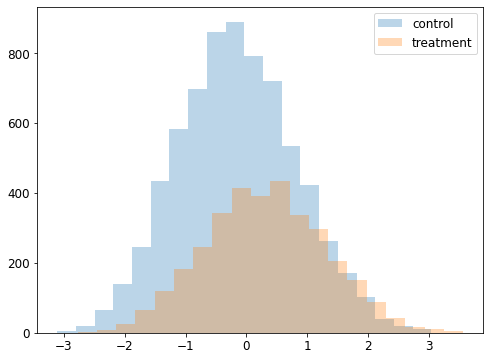

In [5]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# we can check the histogram of our label between the treatment and control
plt.hist(df.loc[df[treatment_col] == 0.0, label_col], bins=20, alpha=0.3, label='control')
plt.hist(df.loc[df[treatment_col] == 1.0, label_col], bins=20, alpha=0.3, label='treatment')
plt.legend()
plt.show()

In [6]:
# fitting a linear regression to estimate the outcome
linear = LinearRegression()
linear.fit(df[[treatment_col]], df[label_col])
print(linear.intercept_, linear.coef_)

-0.15380303423613792 [0.47227167]


In [7]:
smf.ols(f'{label_col} ~ {treatment_col}', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


<div class="alert alert-block alert-info">
<font color=black><br>

- By blindly comparing individuals with and without the intervention, we can see that, on average, those in the treatment group achieved a achievement score 0.4723 higher than the control. 
- Be aware that in this dataset is score was standardized, i.e. it means the treated is 0.4723 standard deviation higher than the untreated.
- Upon establishing the baseline, our next task is to question these numbers. 

<br></font>
</div>

# Propensity Score Estimation

<div class="alert alert-block alert-info">
<font color=black><br>

- The idea behind propensity score is we don't need to directly control for our confounders $X$ to achieve conditional independence $(Y^1,Y^0) \perp T \text{ | } X$. Hence, $Y^1$ denotes the outcome if treatment, $T$, was applied, whereas $Y^0$ measures the outcome if individual was under the control group.
- Instead, it is sufficient to control for a single variable, propensity score, $P(x)$, which is the conditional probability of the treatment, $P(T|X)$. Or in notations form, with our propensity score, we now have $(Y^1,Y^0) \perp T \text{ | } P(X)$.
- Here, we'll use a logistic regression to estimate our propensity score. 
- Feel free to use other classification techniques. 

<br></font>
</div>

In [8]:
input_cols = one_hot_encoded_cols + num_cols

logistic = LogisticRegression()
logistic.fit(df[input_cols], df[treatment_col])

propensity_score = 'propensity_score'
df[propensity_score] = logistic.predict_proba(df[input_cols])[:, 1]
print(df.shape)
df.head()

(10391, 30)


,ethnicity_1,ethnicity_2,ethnicity_3,ethnicity_4,ethnicity_5,ethnicity_6,ethnicity_7,ethnicity_8,ethnicity_9,ethnicity_10,...,school_urbanicity_3,school_urbanicity_4,achievement_score,intervention,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,propensity_score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.277359,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.313030
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-0.449646,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.294726
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.769703,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.313030
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-0.121763,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.313030
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.526147,1.0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.338112


<div class="alert alert-block alert-info">
<font color=black><br>

- It's important to check for score overlap between the treated and untreated population. 
- Looking at the distribution plot below, we can find both treated and untreated individuals in different regions.
- In this case, we have a balanced dataset and our positivity assumption holds true. 
- Remember positivity refers to the scenario where all of the individuals have at least some chance of receiving either treatment and that appears to be the case here. 
- In summary, this would be a situation where we would feel comfortable to proceed with our propensity score matching.
- Note that if we encounter a situation where the propensity score between the treatment and control does not overlap, then we should stop and better construct the prediction that controls for confounding, or in much simpler terms, see if we are missing any important features in our propensity score model. 
- This requires domain knowledge of the data that we are working with. Failing to check for positivity and lack of balance can introduce bias in our estimation as we will be extrapolating the effect to unknown regions.

<br></font>
</div>

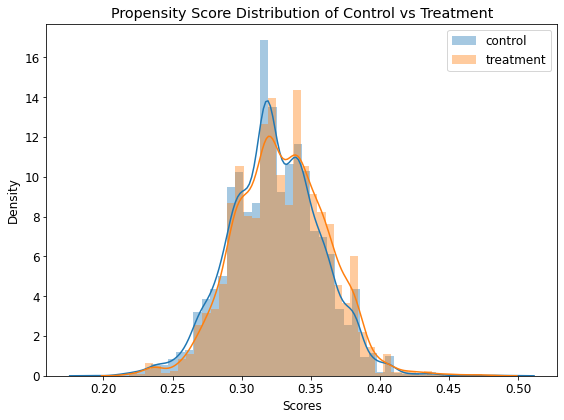

In [9]:
control_score = df.loc[df[treatment_col] == 0.0, propensity_score]
treatment_score = df.loc[df[treatment_col] == 1.0, propensity_score]

sns.distplot(control_score, label='control')
sns.distplot(treatment_score, label='treatment')
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

# Outcome Analysis with Inverse Propensity Score Weighting

<div class="alert alert-block alert-info">
<font color=black><br>

- The final step in our analysis is to run our outcome model using the propensity score as weights, i.e. fit a weighted regression.
- In order to use our propensity score as weights, we will need to apply some transformation known as **Inverse Propensity Weighting (IPW)**. 
- For individuals in the treatment group, $w = \frac{1}{P(x)}$, whereas for individuals in the control group, $w = \frac{1}{1 - P(x)}$.
- To understand why applying inverse propensity weighting helps us de-bias our potentially biased data. 
- Say in the data we collected there are 200 records from group A and 2000 records from group B, to "balance" our dataset, we would like to "up-weight" the records from group A and "down-weight" the records from group B. If we were to weight each records in both groups by number of inverse records, $1 / 200$ for group A, and $1 / 2000$ for group B, we would end up with effectively 1 record on both group.
- Coming back to our example, we are taking all the individuals that are in the treatment group and scaling them with the inverse propensity of being treated $w = \frac{1}{P(x)}$. What this effectively does is it makes those with a very low probability of treatment have a high weight, in other words, we have a individual in the treatment group that looks like he/she should belong to the control group, hence we will give a higher weight to this individual. What this does is create a population with the same size as the original, but where everyone is treated. We can apply the same reasoning for the control group.

<br></font>
</div>

In [10]:
treatment_weight = 1.0 / treatment_score
control_weight = 1.0 / (1.0 - control_score)

print('Original Sample Size', df.shape[0])
print('Treated Population Sample Size', treatment_weight.sum())
print('Untreated Population Sample Size', control_weight.sum())

Original Sample Size 10391
Treated Population Sample Size 10390.32177048764
Untreated Population Sample Size 10390.613009872111


In [11]:
sample_weight = 'sample_weight'
df[sample_weight] = np.where(
    df[treatment_col] == 1.0,
    1.0 / df[propensity_score],
    1.0 / (1.0 - df[propensity_score])
)

Once the sample weight are created, we can re-estimate the outcome with a weighted Linear Regression.

In [12]:
smf.wls(f'{label_col} ~ {treatment_col}', data=df, weights=df[sample_weight]).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1463,0.014,-10.771,0.000,-0.173,-0.120
intervention,0.4430,0.019,23.055,0.000,0.405,0.481


In [13]:
linear = LinearRegression()
linear.fit(df[[treatment_col]], df[label_col], sample_weight=df[sample_weight])
print(linear.intercept_, linear.coef_)

-0.14633238200283927 [0.44298379]


<div class="alert alert-block alert-info">
<font color=black><br>

- Even though scikit-learn's LinearRegression by default doesn't give us an estimated standard error, we can estimate this using bootstrapping. 
- After repeating this step for lots of times, we will get a distribution of the outcome estimation. 
- We will also use this time to organize the overall workflow into one single code cell.

<br></font>
</div>

In [14]:
def run_propensity_score_estimation(df, input_cols, treatment_col, label_col):

    # df is our pre-processed data
    df = df.sample(frac=1, replace=True)

    # estimate the propensity score
    logistic = LogisticRegression()
    logistic.fit(df[input_cols], df[treatment_col])
    propensity_score = logistic.predict_proba(df[input_cols])[:, 1]

    # calculate the inverse propensity weight
    sample_weight = np.where(
        df[treatment_col] == 1.0,
        1.0 / propensity_score,
        1.0 / (1.0 - propensity_score)
    )

    # estimate the outcome using weighted regression
    linear = LinearRegression()
    linear.fit(df[[treatment_col]], df[label_col], sample_weight=sample_weight)
    return linear.coef_[0]

In [15]:
np.random.seed(88)

# the bootstrap approach of computing standard error can be computationally expensive on large datasets.
bootstrap_sample = 1000
parallel = Parallel(n_jobs=4)
ates = parallel(delayed(run_propensity_score_estimation)(df,
                                                         input_cols,
                                                         treatment_col,
                                                         label_col)
                for _ in range(bootstrap_sample))

ates = np.array(ates)
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.44316067964475614
95% C.I.: (0.40296349415700955, 0.48174597763178034)


# Reference

- [Github: Python Causality Handbook - Propensity Score](https://matheusfacure.github.io/python-causality-handbook/11-Propensity-Score.html)
- [Github: Python Causality Handbook - Beyond Confounders](https://matheusfacure.github.io/python-causality-handbook/07-Beyond-Confounders.html)
- [A Practical Guide for Using Propensity Score Weighting in R](http://www.math.umd.edu/~slud/s818M-MissingData/PropensityScoreWeightingR.pdf)
- [Source code used](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/ab_tests/causal_inference/inverse_propensity_weighting.ipynb)

# Conclusion

<div class="alert alert-block alert-danger">
<font color=black><br>

- Aim to include confounding variables, variables that effects both the treatment and the outcome.<br>
- It's a good idea to add variables that predicts the outcome.<br>
- It's a bad idea to add variables that only predicts the treatment, this correlation with the treatment will make it harder for us to detect the true effect of the treatment.<br>

<br></font>
</div>